# LIBRARIES

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torch import optim
import torchmetrics
import onnx

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: markgich (use `wandb login --relogin` to force relogin)


True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DATASET

In [4]:

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)




# VISUALIZE TRAIN IMAGES

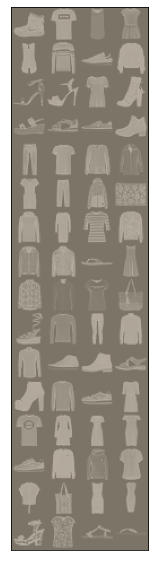

In [5]:
import torchvision

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out,
        #title=[class_names[x] for x in classes],
        ax=ax)

# LINEAR NEURAL NET

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
model.to(device)
model

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=512, out_features=10, bias=True)
    (7): ReLU()
  )
)

#  CONVOLUTION NEURAL NETWORK

class ConvNet(nn.Module):
    def __init__(self, input_shape=(1,28,28)):
        super(ConvNet, self).__init__()

        # DEFINE THE CONVOLUTION LAYERS

        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64,3)
        self.conv3 = nn.Conv2d(64, 128, 3)

        # DEFINE THE POOLING LATER

        self.pool = nn.MaxPool2d(2, 2)

        n_size = self._get_conv_output(input_shape)

        # DEFINE THE LINEAR CLASSS

        self.fc1 = nn.Linear(n_size, 512)
        self.fc2 = nn.Linear(512, 10)

        # DEFINE THE DROPOUT
        self.dropout = nn.Dropout(p=0.25)

    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    def _forward_features(self, X):
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = self.pool(F.relu(self.conv3(X)))
        return X

    def forward(self, X):
        X = self._forward_features(X)
        X = X.view(X.size(0), -1)
        X = self.dropout(X) # DROPOUT
        X = F.relu(self.fc1(X))
        X = self.dropout(X) # DROPOUT
        X = self.fc2(X)
        return X
        
model = ConvNet()

# PUSH MODEL TO DEVICE(CUDA)
model.to(device)
print(model)

# HYPERPARAMETERS

In [7]:
config = dict(learning_rate = 1e-3,
                batch_size = 64,
                epochs = 10,
                loss = nn.CrossEntropyLoss(),
                #loss = nn.NLLLoss(),
                optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-5)
                )

In [8]:
for k, v in config.items():
    print(f"{k}: {v}")

learning_rate: 0.001
batch_size: 64
epochs: 10
loss: CrossEntropyLoss()
optimizer: Adagrad (
Parameter Group 0
    eps: 1e-10
    initial_accumulator_value: 0
    lr: 1e-05
    lr_decay: 0
    weight_decay: 0
)


# TRAINING

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    #acc = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        acc = torchmetrics.functional.accuracy(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"train loss: {loss:>3f}  [{current:>5d}/{size:>5d}]")
            #wandb.log({"train loss": loss, "train accuracy": acc})
    print(f"Train Metrics: \n Train Accuracy: {(100*acc):>0.1f}%, Train Loss: {loss:>8f} \n")
    wandb.log({"Train Accuracy": acc, "Train Loss": loss })


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            acc = torchmetrics.functional.accuracy(pred, y)
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    wandb.log({"Test Accuracy":acc, "Test Loss": test_loss})
    
    #torch.onnx.export(model = model, args=X, f = "./models/fashion_mnist_{X}.onnx", input_names=['input'], output_names = ['output'],
        #verbose=True, do_constant_folding=True, opset_version=11)

    test_loss /= num_batches
    correct /= size
    print(f"Test Metrics: \n Test Accuracy: {(100*acc):>0.1f}%, Test Loss: {test_loss:>8f} \n")



In [10]:
# define loss and optimizer

#loss_fn = nn.NLLLoss()
#loss_fn = config.get("loss")
loss_fn = nn.CrossEntropyLoss()

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adagrad(model.parameters(), lr=config.get("learning_rate"))
#optimizer = config.get("optimizer")

print(loss_fn, optimizer)


CrossEntropyLoss() Adagrad (
Parameter Group 0
    eps: 1e-10
    initial_accumulator_value: 0
    lr: 0.001
    lr_decay: 0
    weight_decay: 0
)


In [11]:
%%time

with wandb.init(project="demo_wandb_fashionmnsit_test", config=config):
    wandb.watch(model, criterion=loss_fn, log="all", log_freq=10)
    #wandb.log({"examples" : [wandb.Image(i) for image,  in images]})
    epochs = 10
    for t in range(epochs):

        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loop(test_dataloader, model, loss_fn)
    
    wandb.save(torch.save(model.state_dict(), f=f"./models/fashion_mnist_{t}.pt"))
    X = torch.randn(16,1,28,28, device='cuda')
    wandb.save(torch.onnx.export(model = model, args=X, f = "./models/fashion_mnist_{t}.onnx", input_names=['input'], output_names = ['output'],
        verbose=True, do_constant_folding=True, opset_version=11))
print("Done!")
torch.cuda.empty_cache()

Epoch 1
-------------------------------
train loss: 2.308867  [    0/60000]
train loss: 1.300207  [ 6400/60000]
train loss: 0.980402  [12800/60000]
train loss: 1.259647  [19200/60000]
train loss: 0.951560  [25600/60000]
train loss: 0.903719  [32000/60000]
train loss: 0.921616  [38400/60000]
train loss: 0.852203  [44800/60000]
train loss: 0.837155  [51200/60000]
train loss: 0.918397  [57600/60000]
Train Metrics: 
 Train Accuracy: 75.0%, Train Loss: 1.087841 

Test Metrics: 
 Test Accuracy: 56.2%, Test Loss: 0.954499 

Epoch 2
-------------------------------
train loss: 0.808192  [    0/60000]
train loss: 0.963371  [ 6400/60000]
train loss: 0.837096  [12800/60000]
train loss: 1.141344  [19200/60000]
train loss: 0.926190  [25600/60000]
train loss: 0.802061  [32000/60000]
train loss: 0.870966  [38400/60000]
train loss: 0.864643  [44800/60000]
train loss: 0.857145  [51200/60000]
train loss: 0.888638  [57600/60000]
Train Metrics: 
 Train Accuracy: 68.8%, Train Loss: 1.021933 

Test Metrics: 

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Test Metrics: 
 Test Accuracy: 62.5%, Test Loss: 0.850117 

graph(%input : Float(16, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cuda:0),
      %linear_relu_stack.0.weight : Float(512, 784, strides=[784, 1], requires_grad=1, device=cuda:0),
      %linear_relu_stack.0.bias : Float(512, strides=[1], requires_grad=1, device=cuda:0),
      %linear_relu_stack.3.weight : Float(512, 512, strides=[512, 1], requires_grad=1, device=cuda:0),
      %linear_relu_stack.3.bias : Float(512, strides=[1], requires_grad=1, device=cuda:0),
      %linear_relu_stack.6.weight : Float(10, 512, strides=[512, 1], requires_grad=1, device=cuda:0),
      %linear_relu_stack.6.bias : Float(10, strides=[1], requires_grad=1, device=cuda:0)):
  %7 : Float(16, 784, strides=[784, 1], requires_grad=0, device=cuda:0) = onnx::Flatten[axis=1](%input) # c:\Users\markg\venv\torch-venv\lib\site-packages\torch\nn\modules\flatten.py:40:0
  %8 : Float(16, 512, strides=[512, 1], requires_grad=1, device=cuda:0) = o

Train Accuracy,0.71875
Train Loss,0.89391
_runtime,142
_timestamp,1626018176
_step,19
Test Accuracy,0.625
Test Loss,133.46839


Train Accuracy,█▁▅▅▅▅▅██▅
Train Loss,█▆▆▃▃▁▂▂▃▁
_runtime,▁▁▂▂▂▃▃▃▄▄▅▅▆▆▆▆▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▅▅▆▆▆▆▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
Test Accuracy,▁▅▅▅▅▅█▅▅▅
Test Loss,█▆▄▄▃▂▂▁▁▁


Done!
Wall time: 2min 26s
